In [314]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

train_full = pd.read_csv("data/train.csv")
train_full_df = train_full.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

prepare_data = lambda df: pd.concat(
        (df.drop(['Sex', 'Embarked', 'Pclass'], axis=1),
        pd.get_dummies(df.Sex),
        pd.get_dummies(df.Embarked, prefix='Em'),
        pd.get_dummies(df.Pclass, prefix='Pclass')),
        axis=1)
train_full_df = prepare_data(train_full_df)
train_full_df = train_full_df.fillna(train_full_df.median())
train_full_df_scaled = MinMaxScaler().fit_transform(train_full_df)

def cutData(xs, ys):
        count = len(xs)
        one_chunk = int(count/5)
        train = (xs[:one_chunk*2], np.array(ys[:one_chunk*2]))
        test = (xs[one_chunk*2:one_chunk*4], np.array(ys[one_chunk*2:one_chunk*4]))
        valid = (xs[one_chunk*4:], np.array(ys[one_chunk*4:]))
        return (train, test, valid)

(train_x, train_y), (test_x, test_y), (valid_x, valid_y) = cutData(train_full_df_scaled, train_full.Survived)

In [315]:
from itertools import product
import random

class HyperparamCalculation():

    def __init__(self,
            iterationsCnt,
            trainData,
            validData,
            setParamFunc,
            seed=100):
        self.bestAccuracy = 0
        self.bestParams = None
        self.iterationsCnt = iterationsCnt
        self.tX, self.tY = trainData
        self.vX, self.vY = validData
        self.parametrize = setParamFunc
        self.seed = seed
    
    @staticmethod
    def calculateAccModel(model, tX, tY):
        predict = np.array(model.predict(tX))
        precision = len(np.where(predict == tY)[0])/len(tY)
        return precision
    
    def printBest(self):
        print(f"Лучшая точность (Validation): {self.bestAccuracy}")
        print(f"Лучшие параметры (Validation): {self.bestParams}")
        return self.bestParams

    def getParams(self):
        return self.bestParams

    def nextParamRandom(self, params):
        randomSeeded = random.Random(self.seed)
        for _ in range(self.iterationsCnt):
            yield randomSeeded.choice(params)
    
    def nextParamIter(self, params):
        for param in params:
            yield param

    @staticmethod
    def calculateAverageAccModel(model, trainData, validData, cntIter):
        accs = []
        for _ in range(cntIter):
            model.fit(trainData[0], trainData[1])
            accs.append(HyperparamCalculation.calculateAccModel(model, validData[0], validData[1]))
        return np.mean(accs)

    def calculate(self, params, testIterationsCnt = 15, paramSelector='random'):
        params = list(product(*params.values()))
        nextParam = self.nextParamRandom
        if paramSelector != 'random':
            nextParam = self.nextParamIter
        for param in nextParam(params):
            model = self.parametrize(param)
            acc = self.calculateAverageAccModel(model, (self.tX, self.tY), (self.vX, self.vY), testIterationsCnt)
            if acc > self.bestAccuracy:
                self.bestAccuracy = acc
                self.bestParams = param
        return self.printBest()

In [316]:
def predictByModel(model, tX, tY, modelName : str = 'None', dataType : str = 'None'):
    precision = HyperparamCalculation.calculateAccModel(model, tX, tY)
    print(f"Точность определения ({dataType}): {round(precision*100,2)}% ({modelName})")

# Случайный лес

In [326]:
from sklearn.ensemble import RandomForestClassifier

paramsRandomForest = {
    "n_estimators": list(range(1, 30)),
    "max_depth": list(range(1, 10)),
    "criterion": ["gini", "entropy", "log_loss"]
}

randomForestParametrizer = lambda p: RandomForestClassifier(n_estimators=p[0], max_depth=p[1], criterion=p[2])
randomForestCalculator = HyperparamCalculation(trainData=(train_x, train_y), validData=(valid_x, valid_y), setParamFunc=randomForestParametrizer, iterationsCnt=50)
randomForestParams = randomForestCalculator.calculate(paramsRandomForest, testIterationsCnt=30)

modelRandomForest = randomForestParametrizer(randomForestParams)
modelRandomForest.fit(train_x, train_y)

result = predictByModel(modelRandomForest, test_x, test_y, modelName="RandomForest", dataType='Test')

Лучшая точность (Validation): 0.8374301675977652
Лучшие параметры (Validation): (22, 5, 'gini')
Точность определения (Test): 78.37% (RandomForest)


### С помощью RandomForest выберите 2, 4, 8 самых важных признаков и проверьте точность моделей только на этих признаках.

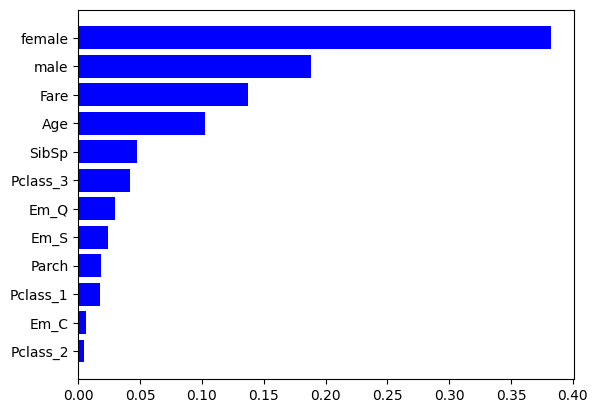

In [318]:
import matplotlib.pyplot as plt

importanceRandomForest = modelRandomForest.feature_importances_
features = train_full_df.columns
indices = np.argsort(importanceRandomForest)
plt.barh(range(len(indices)), importanceRandomForest[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [319]:
bestTagsGroups = []
for cnt in range(2, 9, 2):
    bestTagsGroups.append(list(features[indices][::-1][:cnt]))
params = randomForestCalculator.getParams()
print(f"Используемые гипер-параметры: {params}\n")

for tags in bestTagsGroups:
    modelRandomForest = randomForestParametrizer(params)
    usedDataScaled = MinMaxScaler().fit_transform(train_full_df[tags])
    (train_xC, train_yC), (test_xC, test_yC), _ = cutData(train_full_df_scaled, train_full.Survived)
    
    modelRandomForest.fit(train_xC, train_yC)
    print(f"Признаки: {tags}")
    result = predictByModel(modelRandomForest, test_xC, test_yC, modelName="RandomForest", dataType='Test')
    print("="*50)

Используемые гипер-параметры: (22, 5, 'gini')

Признаки: ['female', 'male']
Точность определения (Test): 78.37% (RandomForest)
Признаки: ['female', 'male', 'Fare', 'Age']
Точность определения (Test): 80.06% (RandomForest)
Признаки: ['female', 'male', 'Fare', 'Age', 'SibSp', 'Pclass_3']
Точность определения (Test): 79.78% (RandomForest)
Признаки: ['female', 'male', 'Fare', 'Age', 'SibSp', 'Pclass_3', 'Em_Q', 'Em_S']
Точность определения (Test): 79.21% (RandomForest)


# XGBClassifier

In [320]:
from xgboost import XGBClassifier

paramsXGBoost = {
    "n_estimators": list(range(1, 30)),
    "max_depth": list(range(1, 10))
}

XGBoostParametrize = lambda p: XGBClassifier(n_estimators=p[0], max_depth=p[1])
XGBoostCalculator = HyperparamCalculation(trainData=(train_x, train_y), validData=(valid_x, valid_y), setParamFunc=XGBoostParametrize, iterationsCnt=30)
XGBoostParams = XGBoostCalculator.calculate(paramsXGBoost, testIterationsCnt=30)

modelXGBoost = XGBoostParametrize(XGBoostParams)
modelXGBoost.fit(train_x, train_y)

result = predictByModel(modelXGBoost, test_x, test_y, modelName="XGBoost", dataType='Test')

Лучшая точность (Validation): 0.8603351955307263
Лучшие параметры (Validation): (15, 9)
Точность определения (Test): 81.18% (XGBoost)


# LogisticRegression

In [321]:
from sklearn.linear_model import LogisticRegression

paramsLogReg = {
    "C": [x/100 for x in range(10, 101, 10)],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

LogRegParametrize = lambda p: LogisticRegression(C=p[0], solver=p[1])
LogRegCalculator = HyperparamCalculation(trainData=(train_x, train_y), validData=(valid_x, valid_y), setParamFunc=LogRegParametrize, iterationsCnt=30)
LogRegParams = LogRegCalculator.calculate(paramsLogReg, testIterationsCnt=30)

modelLogReg = LogRegParametrize(LogRegParams)
modelLogReg.fit(train_x, train_y)

result = predictByModel(modelXGBoost, test_x, test_y, modelName="LogisticRegression", dataType="Test")

Лучшая точность (Validation): 0.8100558659217874
Лучшие параметры (Validation): (0.5, 'saga')
Точность определения (Test): 81.18% (LogisticRegression)


# KNeighborsClassifier

In [322]:
from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier()
modelKNN.fit(train_x, train_y)

result = predictByModel(modelKNN, test_x, test_y, modelName="KNN", dataType='Test')

Точность определения (Test): 77.25% (KNN)
